In [1]:
#!pip install --upgrade pip setuptools wheel
!pip install -r requirements.txt


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


ERROR: Could not find a version that satisfies the requirement tensorflow==2.19.0 (from versions: 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.19.0


In [2]:
import tensorflow as tf
import numpy as np
import ml_dtypes
import streamlit as st

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("ml-dtypes:", ml_dtypes.__version__)
print("Streamlit:", st.__version__)


TensorFlow: 2.20.0
NumPy: 2.3.2
ml-dtypes: 0.5.4
Streamlit: 1.53.0


In [3]:
!pip install alpha_vantage


In [4]:

from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA # Updated import path
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math, random
from datetime import datetime
import datetime as dt
import yfinance as yf
import preprocessor as p
import re
from sklearn.linear_model import LinearRegression
from textblob import TextBlob


In [5]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [6]:
#**************** FUNCTIONS TO FETCH DATA ***************************
def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year-2,end.month,end.day)
    data = yf.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.to_csv(''+quote+'.csv')
    if(df.empty):
        ts = TimeSeries(key='I0TWC260RP30RMO5',output_format='pandas')
        data, meta_data = ts.get_daily_adjusted(symbol='NSE:'+quote, outputsize='full')
        #Format df
        #Last 2 yrs rows => 502, in ascending order => ::-1
        data=data.head(503).iloc[::-1]
        data=data.reset_index()
        #Keep Required cols only
        df=pd.DataFrame()
        df['Date']=data['date']
        df['Open']=data['1. open']
        df['High']=data['2. high']
        df['Low']=data['3. low']
        df['Close']=data['4. close']
        df['Adj Close']=data['5. adjusted close']
        df['Volume']=data['6. volume']
        df.to_csv(''+quote+'.csv',index=False)
    return


In [7]:
#******************** ARIMA SECTION ********************
def ARIMA_ALGO(df):
    uniqueVals = df["Code"].unique()
    len(uniqueVals)
    df=df.set_index("Code")
    #for daily basis
    def parser(x):
        return datetime.strptime(x, '%Y-%m-%d')
    def arima_model(train, test):
        history = [x for x in train]
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=(6,1 ,0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat[0])
            obs = test[t]
            history.append(obs)
        return predictions
    for company in uniqueVals[:10]:
        data=(df.loc[company,:]).reset_index()
        data['Price'] = data['Close']
        Quantity_date = data[['Price','Date']]
        Quantity_date.index = Quantity_date['Date'].map(lambda x: parser(x))
        Quantity_date['Price'] = Quantity_date['Price'].map(lambda x: float(x))
        Quantity_date = Quantity_date.fillna(Quantity_date.bfill())
        Quantity_date = Quantity_date.drop(['Date'],axis =1)
        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(Quantity_date)
        #plt.savefig('Trends.png')
        #plt.close(fig)

        quantity = Quantity_date.values
        size = int(len(quantity) * 0.80)
        train, test = quantity[0:size], quantity[size:len(quantity)]
        #fit in model
        predictions = arima_model(train, test)

        #plot graph
        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(test,label='Actual Price')
        plt.plot(predictions,label='Predicted Price')
        plt.legend(loc=4)
        #plt.savefig('ARIMA.png')
        #plt.close(fig)
        print()
        print("##############################################################################")
        arima_pred=predictions[-2]
        print("Tomorrow's",quote," Closing Price Prediction by ARIMA:",arima_pred)
        #rmse calculation
        error_arima = math.sqrt(mean_squared_error(test, predictions))
        print("ARIMA RMSE:",error_arima)
        print("##############################################################################")
        return arima_pred, error_arima

In [8]:
#************* LSTM SECTION **********************

def LSTM_ALGO(df_input):
    df = df_input.copy()

    # Ensure 'Close' column is numeric and drop any rows where it's not a valid number
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df = df.dropna(subset=['Close']).reset_index(drop=True)

    #Split data into training set and test set
    # These should be based on the cleaned df
    dataset_train=df.iloc[0:int(0.8*len(df)),:]
    dataset_test=df.iloc[int(0.8*len(df)):,:]

    ############# NOTE #################
    #TO PREDICT STOCK PRICES OF NEXT N DAYS, STORE PREVIOUS N DAYS IN MEMORY WHILE TRAINING
    # HERE N=7
    ###dataset_train=pd.read_csv('Google_Stock_Price_Train.csv')
    # Select the 'Close' price column for training
    training_set=df[['Close']].values # Correctly selecting 'Close' column
    #select cols using above manner to select as float64 type, view in var explorer

    #Feature Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc=MinMaxScaler(feature_range=(0,1))#Scaled values btween 0,1
    training_set_scaled=sc.fit_transform(training_set)
    #In scaling, fit_transform for training, transform for test

    #Creating data stucture with 7 timesteps and 1 output.
    #7 timesteps meaning storing trends from 7 days before current day to predict 1 next output
    X_train=[]#memory with 7 days from day i
    y_train=[]#day i
    for i in range(7,len(training_set_scaled)):
        X_train.append(training_set_scaled[i-7:i,0])
        y_train.append(training_set_scaled[i,0])
    #Convert list to numpy arrays
    X_train=np.array(X_train)
    y_train=np.array(y_train)
    X_forecast=np.array(X_train[-1,1:])
    X_forecast=np.append(X_forecast,y_train[-1])
    #Reshaping: Adding 3rd dimension
    X_train=np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))#.shape 0=row,1=col
    X_forecast=np.reshape(X_forecast, (1,X_forecast.shape[0],1))
    #For X_train=np.reshape(no. of rows/samples, timesteps, no. of cols/features)

    #Building RNN
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import LSTM

    #Initialise RNN
    regressor=Sequential()

    #Add first LSTM layer
    regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
    #units=no. of neurons in layer
    #input_shape=(timesteps,no. of cols/features)
    #return_seq=True for sending recc memory. For last layer, retrun_seq=False since end of the line
    regressor.add(Dropout(0.1))

    #Add 2nd LSTM layer
    regressor.add(LSTM(units=50,return_sequences=True))
    regressor.add(Dropout(0.1))

    #Add 3rd LSTM layer
    regressor.add(LSTM(units=50,return_sequences=True))
    regressor.add(Dropout(0.1))

    #Add 4th LSTM layer
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.1))

    #Add o/p layer
    regressor.add(Dense(units=1))

    #Compile
    regressor.compile(optimizer='adam',loss='mean_squared_error')

    #Training
    regressor.fit(X_train,y_train,epochs=25,batch_size=32 )
    #For lstm, batch_size=power of 2

    #Testing
    ###dataset_test=pd.read_csv('Google_Stock_Price_Test.csv')
    real_stock_price=dataset_test[['Close']].values # Correctly selecting 'Close' column

    #To predict, we need stock prices of 7 days before the test set
    #So combine train and test set to get the entire data set
    dataset_total=pd.concat((dataset_train['Close'],dataset_test['Close']),axis=0)
    testing_set=dataset_total[ len(dataset_total) -len(dataset_test) -7: ].values
    testing_set=testing_set.reshape(-1,1)
    #-1=till last row, (-1,1)=>(80,1). otherwise only (80,0)

    #Feature scaling
    testing_set=sc.transform(testing_set)

    #Create data structure
    X_test=[]
    for i in range(7,len(testing_set)):
        X_test.append(testing_set[i-7:i,0])
        #Convert list to numpy arrays
    X_test=np.array(X_test)

    #Reshaping: Adding 3rd dimension
    X_test=np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    #Testing Prediction
    predicted_stock_price=regressor.predict(X_test)

    #Getting original prices back from scaled values
    predicted_stock_price=sc.inverse_transform(predicted_stock_price)
    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    plt.plot(real_stock_price,label='Actual Price')
    plt.plot(predicted_stock_price,label='Predicted Price')
    plt.legend(loc=4)

    #plt.savefig('static/LSTM.png')
    #plt.close(fig)


    error_lstm = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))


    #Forecasting Prediction
    forecasted_stock_price=regressor.predict(X_forecast)

    #Getting original prices back from scaled values
    forecasted_stock_price=sc.inverse_transform(forecasted_stock_price)

    lstm_pred=forecasted_stock_price[0,0]
    print()
    print("##############################################################################")
    print("Tomorrow's ",quote," Closing Price Prediction by LSTM: ",lstm_pred)
    print("LSTM RMSE:",error_lstm)
    print("##############################################################################")
    return lstm_pred,error_lstm


In [9]:
#***************** LINEAR REGRESSION SECTION ******************
def LIN_REG_ALGO(df_input):
    df = df_input.copy()

    # Ensure 'Close' column is numeric and drop any rows where it's not a valid number
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df = df.dropna(subset=['Close']).reset_index(drop=True)

    #No of days to be forcasted in future
    forecast_out = int(7)
    #Price after n days
    df['Close after n days'] = df['Close'].shift(-forecast_out)
    #New df with only relevant data
    df_new=df[['Close','Close after n days']]

    #Structure data for train, test & forecast
    #lables of known data, discard last 35 rows
    y =np.array(df_new.iloc[:-forecast_out,-1])
    y=np.reshape(y, (-1,1))
    #all cols of known data except lables, discard last 35 rows
    X=np.array(df_new.iloc[:-forecast_out,0:-1])
    #Unknown, X to be forecasted
    X_to_be_forecasted=np.array(df_new.iloc[-forecast_out:,0:-1])

    #Traning, testing to plot graphs, check accuracy
    X_train=X[0:int(0.8*len(df)),:]
    X_test=X[int(0.8*len(df)):,:]
    y_train=y[0:int(0.8*len(df)),:]
    y_test=y[int(0.8*len(df)):,:] # Corrected this line

    # Feature Scaling===Normalization
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    X_to_be_forecasted=sc.transform(X_to_be_forecasted)

    #Training
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)

    #Testing
    y_test_pred=clf.predict(X_test)
    y_test_pred=y_test_pred*(1.04)
    import matplotlib.pyplot as plt2
    fig = plt2.figure(figsize=(7.2,4.8),dpi=65)
    plt2.plot(y_test,label='Actual Price' )
    plt2.plot(y_test_pred,label='Predicted Price')

    plt2.legend(loc=4)

    #plt2.savefig('static/LR.png')
    #plt2.close(fig)

    error_lr = math.sqrt(mean_squared_error(y_test, y_test_pred))


    #Forecasting
    forecast_set = clf.predict(X_to_be_forecasted)
    forecast_set=forecast_set*(1.04)
    mean=forecast_set.mean()
    lr_pred=forecast_set[0,0]
    print()
    print("##############################################################################")
    print("Tomorrow's ",quote," Closing Price Prediction by Linear Regression: ",lr_pred)
    print("Linear Regression RMSE:",error_lr)
    print("##############################################################################")
    return df, lr_pred, forecast_set, mean, error_lr

In [10]:
quote = input("Enter stock ticker symbol: ")

In [11]:
get_historical(quote)
#************** PREPROCESSING ***********************
df = pd.read_csv(''+quote+'.csv')
print("##############################################################################")
print("Today's",quote,"Stock Data: ")
today_stock=df.iloc[-1:]
print(today_stock)
print("##############################################################################")
df = df.dropna()
code_list=[]
for i in range(0,len(df)):
    code_list.append(quote)
df2=pd.DataFrame(code_list,columns=['Code'])
df2 = pd.concat([df2, df], axis=1)
df=df2

[*********************100%***********************]  1 of 1 completed

##############################################################################
Today's NKE Stock Data: 
          Price              Close               High                Low  \
502  2026-01-20  64.19000244140625  64.57990264892578  63.36000061035156   

                 Open   Volume  
502  63.4900016784668  7883882  
##############################################################################



##############################################################################
Tomorrow's NKE  Closing Price Prediction by ARIMA: 65.6733244444432
ARIMA RMSE: 1.4609210258043277
##############################################################################


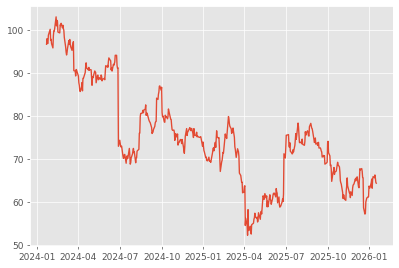

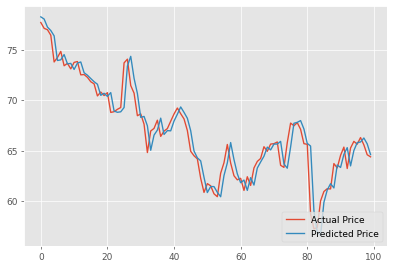

In [12]:
import pandas as pd
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Re-defining ARIMA_ALGO to fix the issue based on the observed 'df' structure.
def ARIMA_ALGO(df_input):
    # Make a copy to avoid modifying the original DataFrame outside the function scope.
    df = df_input.copy()

    # Based on the kernel state, the 'Price' column contains date-like strings
    # but might also contain 'Ticker' and NaN values at the beginning.
    # The ARIMA_ALGO expects a 'Date' column containing valid date strings.

    # 1. Clean the 'df' to ensure the 'Price' column has only valid date strings.
    # Convert 'Price' column to datetime, coercing errors to NaN for non-date strings.
    df['TempDate'] = pd.to_datetime(df['Price'], errors='coerce')
    # Filter out rows where 'TempDate' is NaN (i.e., 'Price' was not a valid date string).
    df = df[df['TempDate'].notna()].reset_index(drop=True)
    # Drop the temporary datetime column.
    df = df.drop(columns=['TempDate'])

    # 2. Rename the 'Price' column to 'Date' as expected by the ARIMA_ALGO logic.
    if 'Price' in df.columns:
        df = df.rename(columns={'Price': 'Date'})

    uniqueVals = df["Code"].unique()

    df=df.set_index("Code")
    #for daily basis
    def parser(x):
        # Ensure x is converted to string before parsing, as it might be a Timestamp object already after the previous conversion.
        return datetime.strptime(str(x), '%Y-%m-%d')
    def arima_model(train, test):
        history = [x for x in train]
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=(6,1 ,0))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
        return predictions
    for company in uniqueVals[:10]:
        data=(df.loc[company,:]).reset_index()

        # Corrected approach:
        # Select 'Close' as the value to predict and 'Date' as the time index.
        Quantity_date = data[['Close','Date']].copy()

        Quantity_date.index = Quantity_date['Date'].map(lambda x: parser(x))
        Quantity_date['Close'] = Quantity_date['Close'].map(lambda x: float(x)) # Ensure 'Close' is float

        Quantity_date = Quantity_date.fillna(Quantity_date.bfill())
        Quantity_date = Quantity_date.drop(['Date'],axis =1) # Drop the 'Date' column after setting it as index

        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(Quantity_date)

        quantity = Quantity_date.values
        size = int(len(quantity) * 0.80)
        train, test = quantity[0:size], quantity[size:len(quantity)]
        #fit in model
        predictions = arima_model(train, test)

        #plot graph
        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(test,label='Actual Price')
        plt.plot(predictions,label='Predicted Price')
        plt.legend(loc=4)

        print()
        print("##############################################################################")
        arima_pred=predictions[-2]
        print("Tomorrow's",quote," Closing Price Prediction by ARIMA:",arima_pred)
        #rmse calculation
        error_arima = math.sqrt(mean_squared_error(test, predictions))
        print("ARIMA RMSE:",error_arima)
        print("##############################################################################")
        return arima_pred, error_arima

arima_pred, error_arima=ARIMA_ALGO(df)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0952
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0248
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0144
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0073
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0074
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0069
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0073
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0073
Epoch 10/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066
Epoch 11/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068
Epoch 12/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061
Epoch 13/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067
Epoch 14/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063
Epoch 15/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064
Epoc

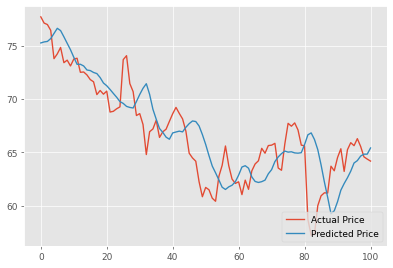

In [13]:
lstm_pred, error_lstm=LSTM_ALGO(df)


##############################################################################
Tomorrow's  NKE  Closing Price Prediction by Linear Regression:  69.45642073592256
Linear Regression RMSE: 5.520433200733039
##############################################################################


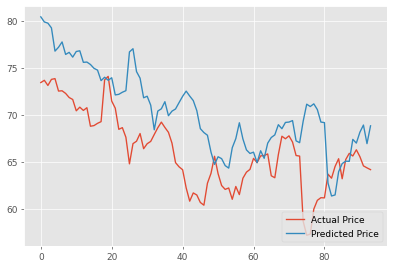

In [14]:
 df, lr_pred, forecast_set,mean,error_lr=LIN_REG_ALGO(df)

In [15]:
from textblob import TextBlob
import nltk
nltk.download('punkt')
class Tweet(object):

    def __init__(self, content, polarity):
        self.content = content
        self.polarity = polarity

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
#------------SENTIMENT ANALYSIS------------------
def retrieving_tweets_polarity_from_csv(csv_path):
    df = pd.read_csv(csv_path)

    global_polarity = 0
    pos, neg, neutral = 0, 0, 0
    tw_list = []

    for text in df['text']:
        text = p.clean(text)
        text = re.sub('&','&', text)
        text = re.sub(':','', text)
        text = text.encode('ascii', 'ignore').decode('ascii')

        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        global_polarity += polarity

        if polarity > 0:
            pos += 1
        elif polarity < 0:
            neg += 1
        else:
            neutral += 1

        tw_list.append(text)

    total = pos + neg + neutral
    global_polarity = global_polarity / total if total != 0 else 0

    print()
    print("##############################################################################")
    print("Positive Tweets :", pos, "Negative Tweets :", neg, "Neutral Tweets :", neutral)
    print("##############################################################################")

    if global_polarity > 0:
        tw_pol = "Overall Positive"
        print("Tweets Polarity: Overall Positive")
    else:
        tw_pol = "Overall Negative"
        print("Tweets Polarity: Overall Negative")

    print("##############################################################################")

    return global_polarity, tw_list, tw_pol, pos, neg, neutral


In [17]:
#---------RECOMENDATIONS BASED ON TWEETS & Models-------------------
def recommending(df, global_polarity, today_stock, mean):

    mean = float(mean)
    today_close = float(today_stock.iloc[-1]['Close'])

    if today_close < mean:
        if global_polarity > 0:
            idea = "RISE"
            decision = "BUY"
        else:
            idea = "FALL"
            decision = "SELL"
    else:
        idea = "FALL"
        decision = "SELL"

    print()
    print("##############################################################################")
    print("According to the ML Predictions and Sentiment Analysis, a", idea,
          "in", quote, "stock is expected =>", decision)
    print("##############################################################################")

    return idea, decision


In [18]:
#Showing sentiment analysis
polarity, tw_list, tw_pol, pos, neg, neutral = retrieving_tweets_polarity_from_csv("tweets.csv")


##############################################################################
Positive Tweets : 6706 Negative Tweets : 16638 Neutral Tweets : 26656
##############################################################################
Tweets Polarity: Overall Negative
##############################################################################


In [19]:
idea, decision=recommending(df, polarity,today_stock,mean)
print()
print("Forecasted Prices for Next 7 days:")
print(forecast_set)


##############################################################################
According to the ML Predictions and Sentiment Analysis, a FALL in NKE stock is expected => SELL
##############################################################################

Forecasted Prices for Next 7 days:
[[69.45642074]
 [69.19687762]
 [69.80866388]
 [69.13199184]
 [68.22358386]
 [68.02892653]
 [67.85281203]]
